In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mhdataset/MHDataset.csv


In [5]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import layers
from keras.optimizers import Adam

In [6]:
df = pd.read_csv('/kaggle/input/mhdataset/MHDataset.csv')

In [7]:
df = df.drop(labels=[df.keys()[0]], axis=1) #drop duplicate id column
df['status'] = df['status'].str.lower() #convert to lowercase

#list-ify status and rename to disorder
mental_health = []
for status in df['status']:
    mental_health.append([status])

mental_health = pd.Series(mental_health, name='disorder')
df = pd.concat([df, mental_health], axis=1)
df = df.drop(columns=['status'])

if df.isna().any().any(): #Check for NaN values
    df.dropna(axis=0, inplace=True) #Drop NaN values

In [8]:
df['statement'].apply(lambda x: len(x.split(" "))).describe()

count    52681.000000
mean       113.035914
std        163.501877
min          1.000000
25%         15.000000
50%         62.000000
75%        148.000000
max       6300.000000
Name: statement, dtype: float64

In [9]:
df = df[df['statement'].apply(lambda x: len(x.split(" "))) <= 150]

In [10]:
train_df, other = train_test_split(
    df,
    test_size = 0.10, #90 train, 10 val/test
    random_state = 1295,
    shuffle = True,
    stratify = df['disorder'],
)

val_df, test_df = train_test_split(
    other,
    test_size = 0.5, #5 val/5 test,
    random_state = 1295,
    shuffle = True,
    stratify = other['disorder'],
)

In [11]:
print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 35786
Number of rows in validation set: 1988
Number of rows in test set: 1989


In [12]:
disorders = tf.ragged.constant(train_df['disorder'].values)

#String Lookup Layer
lookup_layer = layers.StringLookup(output_mode="multi_hot")
lookup_layer.adapt(disorders)

vocab = lookup_layer.get_vocabulary()
print(vocab)

['[UNK]', 'normal', 'depression', 'suicidal', 'anxiety', 'stress', 'bipolar', 'personality disorder']


In [13]:
sample_label = train_df['disorder'].iloc[1212]
print(f"Original Label: {sample_label}")

binarized_label = lookup_layer([sample_label])
print(f"Binary Encoded Label: {binarized_label}")

Original Label: ['normal']
Binary Encoded Label: [[0 1 0 0 0 0 0 0]]


In [14]:
BATCH_SIZE = 64
padding_token = "[PAD]"
auto = tf.data.AUTOTUNE

In [15]:
def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe['disorder'].values)
    label_binarized = lookup_layer(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe['statement'].values, label_binarized)
    )
    dataset = dataset.shuffle(BATCH_SIZE * 10) if is_train else dataset
    return dataset.batch(BATCH_SIZE)

In [16]:
def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

In [17]:
train_dataset = make_dataset(train_df, is_train=True)
val_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [18]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Statement: {text}")
    print(f"Disorder: {invert_multi_hot(label[0])}")
    print(" ")

Statement: b'I got nothing to talk about, I never go out and do not have any friends. All I do is game out, stay home and listen music. I do not drink, I do not do drugs, I do not even smoke. I hate this feeling where I have nobody to talk to, I cannot even a real conversation with family. I feel worthless. I got nobody to talk to... and I always need someone to talk, but....'
Disorder: ['depression']
 
Statement: b'kameelahwrites lt codez they ve been mia tho'
Disorder: ['normal']
 
Statement: b'I was talking to a friend about how I always think it would be great to just never wake up, or be suddenly killed, etc. She was super freaked out and said she did not realize I am suicidal I was trying to explain that I am not going to hurt myself, it would just be cool to not exist anymore, and that is just normal for me. Has your normal ever freaked someone out? Does your normal make others nervous?'
Disorder: ['depression']
 
Statement: b'My brain is a mess, a fucking mess. I do not know ho

In [19]:
#Vocabulary
vocabulary = set()
train_df['statement'].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

71862


In [20]:
text_vectorizer = layers.TextVectorization(
    max_tokens = vocabulary_size,
    standardize = "lower_and_strip_punctuation",
    split = "whitespace",
    ngrams = 2,
    output_mode = "tf_idf",
)

In [21]:
text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

In [22]:
train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

val_dataset = val_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [23]:
def BasicMHModel():
    model = keras.Sequential([
        layers.Dense(units=256, activation='relu'),
        layers.Dense(units=128, activation='relu'),
        layers.Dropout(rate=0.1),
        layers.Dense(units=lookup_layer.vocabulary_size(), activation='softmax')
    ])
    return model

In [24]:
model = BasicMHModel()
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=1e-3),
    metrics = ['accuracy']
)

In [25]:
callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
    start_from_epoch=2,
)

In [26]:
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 10,
    callbacks = [callback]
)

Epoch 1/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 959s 2s/step - accuracy: 0.6991 - loss: 0.9206 - val_accuracy: 0.8053 - val_loss: 0.5253
Epoch 2/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 974s 2s/step - accuracy: 0.9520 - loss: 0.1437 - val_accuracy: 0.8063 - val_loss: 0.6667
Epoch 3/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 939s 2s/step - accuracy: 0.9917 - loss: 0.0341 - val_accuracy: 0.7948 - val_loss: 0.8271
Epoch 4/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 1001s 2s/step - accuracy: 0.9964 - loss: 0.0233 - val_accuracy: 0.7928 - val_loss: 0.9657
Epoch 5/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 942s 2s/step - accuracy: 0.9965 - loss: 0.0171 - val_accuracy: 0.7746 - val_loss: 1.0136
Epoch 6/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 981s 2s/step - accuracy: 0.9970 - loss: 0.0146 - val_accuracy: 0.7777 - val_loss: 1.0774
Epoch 7/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 943s 2s/step - accuracy: 0.9974 - loss: 0.0097 - val_accuracy: 0.7802 - val_loss: 1.1814
Epoch 8/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 972s 2s/step - accuracy: 0.9964 - loss: 0.0129 - val_acc

In [27]:
import matplotlib.pyplot as plt

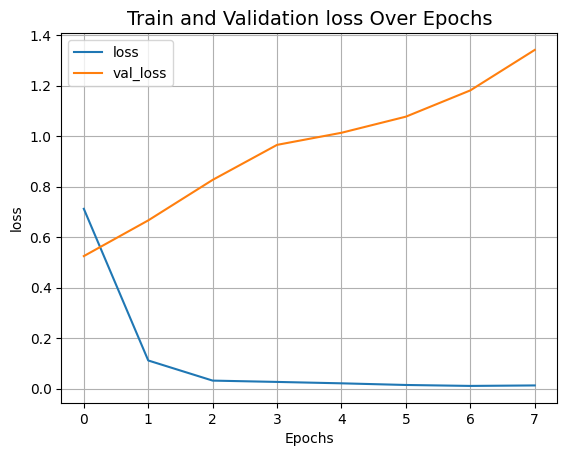

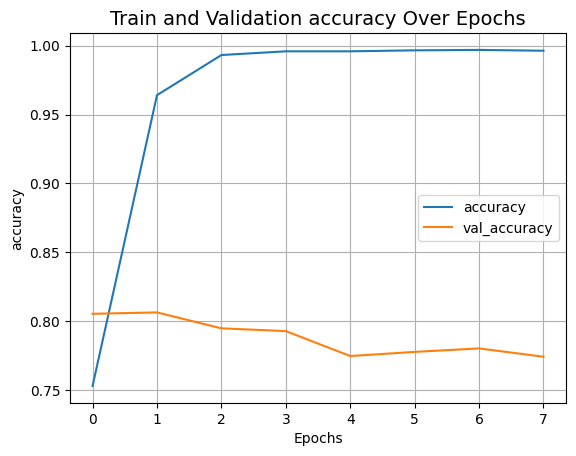

In [28]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

In [29]:
_, accuracy = model.evaluate(test_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7769 - loss: 1.0711


In [30]:
print(f"Categorical accuracy on the test set: {round(accuracy * 100, 2)}%.")

Categorical accuracy on the test set: 78.18%.
